## EDA

### Read Training Data

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set float display to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Wranings 
import warnings
warnings.filterwarnings('ignore')

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 3, Finished, Available, Finished)

In [2]:
# Read df
train_df = pd.read_parquet("/lakehouse/default/Files/train")
display(train_df)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f5335065-7396-431c-bae1-62bc268b13d0)

In [3]:
# Info 
train_df.info()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 5, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   pickup_datetime       datetime64[ns]
 2   trip_miles            float64       
 3   trip_time             int64         
 4   base_passenger_fare   float64       
 5   tolls                 float64       
 6   bcf                   float64       
 7   sales_tax             float64       
 8   congestion_surcharge  float64       
 9   airport_fee           float64       
 10  tips                  float64       
 11  driver_pay            float64       
 12  shared_request_flag   object        
 13  shared_match_flag     object        
 14  access_a_ride_flag    object        
 15  wav_request_flag      object        
 16  wav_match_flag        object        
 17  cbd_congestion_fee    float64       
 18  week_number           UInt32        
dty

In [4]:
# Describe() 
train_df.select_dtypes(['float64','int64']).describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 6, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.12,1218.97,28.00,1.12,0.70,2.33,0.97,0.23,1.24,21.60,0.51
std,6.01,898.32,25.70,3.63,0.67,2.12,1.31,0.72,3.72,18.91,0.71
min,0.01,1.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
25%,1.56,600.00,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00
50%,3.03,978.00,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00
75%,6.42,1566.00,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50
max,266.56,29430.00,1069.28,65.59,26.73,97.29,5.50,10.00,179.14,692.87,3.00


In [5]:
# Shape ?
print("Shape of training data:", train_df.shape)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 7, Finished, Available, Finished)

Shape of training data: (2000000, 19)


In [6]:
# Nulls in data?
train_df.isnull().sum()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 8, Finished, Available, Finished)

hvfhs_license_num       0
pickup_datetime         0
trip_miles              0
trip_time               0
base_passenger_fare     0
tolls                   0
bcf                     0
sales_tax               0
congestion_surcharge    0
airport_fee             0
tips                    0
driver_pay              0
shared_request_flag     0
shared_match_flag       0
access_a_ride_flag      0
wav_request_flag        0
wav_match_flag          0
cbd_congestion_fee      0
week_number             0
dtype: int64

### Derived features

In [7]:
# new df 
train_df1 = train_df.copy()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 9, Finished, Available, Finished)

In [8]:
# Shape 
train_df1.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 10, Finished, Available, Finished)

(2000000, 19)

In [9]:
# Time-based features
train_df1['pickup_hour'] = train_df1['pickup_datetime'].dt.hour
train_df1['pickup_dayofweek'] = train_df1['pickup_datetime'].dt.dayofweek
train_df1['is_weekend'] = train_df1['pickup_dayofweek'].isin([5, 6]).astype(int)
train_df1['pickup_dayofmonth'] = train_df1['pickup_datetime'].dt.day
# Time of day category (morning, afternoon, night, etc.)
train_df1['time_of_day'] = pd.cut(train_df1['pickup_hour'], bins=[0,6,12,18,24], 
        labels=['Night','Morning','Afternoon','Evening'], right=False)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 11, Finished, Available, Finished)

In [10]:
# Write train_df4 to lakehouse engineered folder
train_df1.to_parquet("/lakehouse/default/Files/engineered/train_df1.parquet")

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 12, Finished, Available, Finished)

In [11]:
# Business features 
train_df1['driver_pay_per_mile'] = train_df1.apply(
    lambda row: row['driver_pay'] / row['trip_miles'] if row['trip_miles'] > 0 else None,
    axis=1)

train_df1['is_high_tip'] = ((train_df1['tips'] / train_df1['base_passenger_fare']) > 0.2).astype(int)
train_df1['is_night_ride'] = train_df1['pickup_hour'].apply(lambda x: 1 if x >= 22 or x <= 5 else 0)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 13, Finished, Available, Finished)

#### 1/0 encoding select features 
For features showing Y/N values

In [12]:
# Set columns
columns_for_mapping = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 
                        'wav_request_flag', 'wav_match_flag']

# Mapping features with Y/N to 1/0
mapping = {'Y': 1, 'N': 0}

# Loop through columns, map to new values from dic
for col in columns_for_mapping: 
    train_df1[col] = train_df1[col].map(mapping)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 14, Finished, Available, Finished)

In [13]:
train_df1.info()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 15, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 27 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   pickup_datetime       datetime64[ns]
 2   trip_miles            float64       
 3   trip_time             int64         
 4   base_passenger_fare   float64       
 5   tolls                 float64       
 6   bcf                   float64       
 7   sales_tax             float64       
 8   congestion_surcharge  float64       
 9   airport_fee           float64       
 10  tips                  float64       
 11  driver_pay            float64       
 12  shared_request_flag   int64         
 13  shared_match_flag     int64         
 14  access_a_ride_flag    int64         
 15  wav_request_flag      int64         
 16  wav_match_flag        int64         
 17  cbd_congestion_fee    float64       
 18  week_number           UInt32        
 19

In [14]:
# Display 
display(train_df1)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7f902caa-fbcb-43b1-bc02-3767235a9069)

### Outliers

In [15]:
# Select continuous variables 
continous_features = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 
        'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
        'cbd_congestion_fee', 'driver_pay_per_mile']
continous_features

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 17, Finished, Available, Finished)

['trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'cbd_congestion_fee',
 'driver_pay_per_mile']

In [16]:
# Winsorize and cap-off extreme values 
from scipy.stats.mstats import winsorize

# Copy df3
train_df1_winsorized = train_df1.copy()

# Winsorize all numeric columns at 1st and 99th percentiles
for col in train_df1_winsorized[continous_features].columns:
    lower = train_df1_winsorized[col].quantile(0.01)
    upper = train_df1_winsorized[col].quantile(0.99)
    train_df1_winsorized[col] = train_df1_winsorized[col].clip(lower, upper)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 18, Finished, Available, Finished)

In [17]:
train_df1[continous_features].describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 19, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.12,1218.97,28.00,1.12,0.70,2.33,0.97,0.23,1.24,21.60,0.51,5.69
std,6.01,898.32,25.70,3.63,0.67,2.12,1.31,0.72,3.72,18.91,0.71,9.99
min,0.01,1.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01
25%,1.56,600.00,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00,3.84
50%,3.03,978.00,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00,4.91
75%,6.42,1566.00,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50,6.30
max,266.56,29430.00,1069.28,65.59,26.73,97.29,5.50,10.00,179.14,692.87,3.00,6478.00


In [18]:
train_df1_winsorized[continous_features].describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 20, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.00,1209.28,27.55,1.07,0.69,2.29,0.97,0.22,1.16,21.28,0.51,5.54
std,5.20,846.95,22.73,3.34,0.59,1.93,1.31,0.71,3.11,16.94,0.71,2.69
min,0.48,194.00,6.19,0.00,0.13,0.00,0.00,0.00,0.00,4.00,0.00,2.44
25%,1.56,600.00,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00,3.84
50%,3.03,978.00,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00,4.91
75%,6.42,1566.00,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50,6.30
max,27.69,4459.00,129.90,18.52,3.34,10.55,2.75,2.50,18.03,91.44,1.50,18.30


### Univariate Analysis
of Target variable 

In [19]:
# Copy df 
train_df2 = train_df1_winsorized.copy()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 21, Finished, Available, Finished)

In [20]:
# Shape 
train_df2.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 22, Finished, Available, Finished)

(2000000, 27)

#### Distributions

In [22]:
train_df2.select_dtypes('float64').describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 24, Finished, Available, Finished)

,trip_miles,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.00,27.55,1.07,0.69,2.29,0.97,0.22,1.16,21.28,0.51,5.54
std,5.20,22.73,3.34,0.59,1.93,1.31,0.71,3.11,16.94,0.71,2.69
min,0.48,6.19,0.00,0.13,0.00,0.00,0.00,0.00,4.00,0.00,2.44
25%,1.56,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00,3.84
50%,3.03,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00,4.91
75%,6.42,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50,6.30
max,27.69,129.90,18.52,3.34,10.55,2.75,2.50,18.03,91.44,1.50,18.30


In [27]:
train_df2.driver_pay[train_df2['driver_pay'] < train_df2['driver_pay'].quantile(0.99)]

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 29, Finished, Available, Finished)

11322195   32.46
12984601   25.17
5431662     5.61
15867325   19.30
13701913   16.53
            ... 
2374351    22.00
7060383    44.22
687684     11.17
14752371   66.08
6340764    11.18
Name: driver_pay, Length: 1979989, dtype: float64

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 36, Finished, Available, Finished)

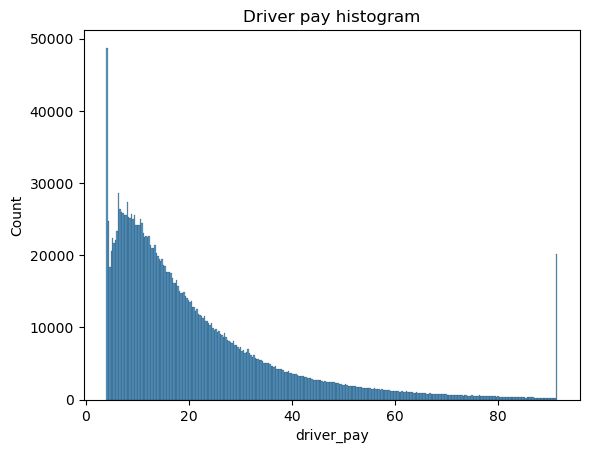

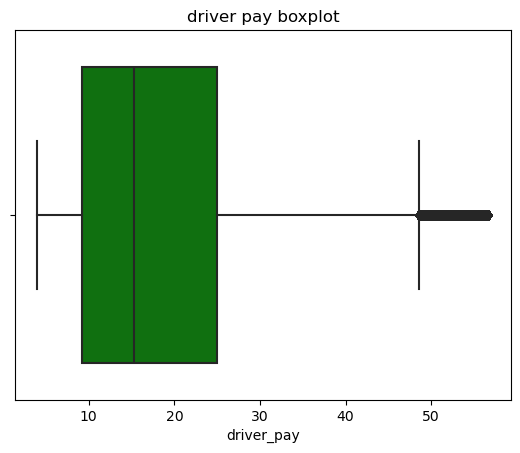

In [34]:
# Histogram
sns.histplot(train_df2.driver_pay)
plt.title ("Driver pay histogram")
plt.show()
# Boxplot 
sns.boxplot(x=train_df2.driver_pay[train_df2['driver_pay'] < train_df2['driver_pay'].quantile(0.95)], 
                orient='horizontal', color='green')
plt.title ("driver pay boxplot")
plt.show()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 38, Finished, Available, Finished)

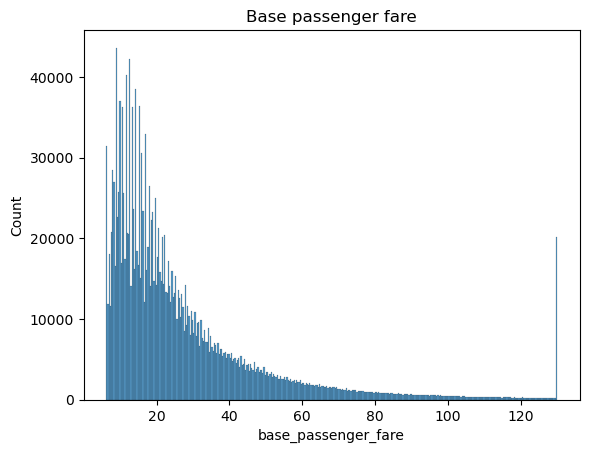

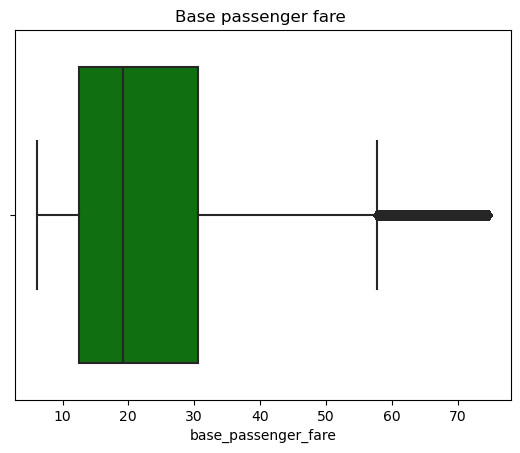

In [36]:
# Histogram fare amount 
sns.histplot(train_df2.base_passenger_fare)
plt.title ("Base passenger fare")
plt.show()
# Boxplot 
sns.boxplot(x=train_df2.base_passenger_fare[train_df2['base_passenger_fare'] 
                < train_df2['base_passenger_fare'].quantile(0.95)], color='green')
plt.title ("Base passenger fare ")
plt.show()

#### Scatter Plots

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 39, Finished, Available, Finished)

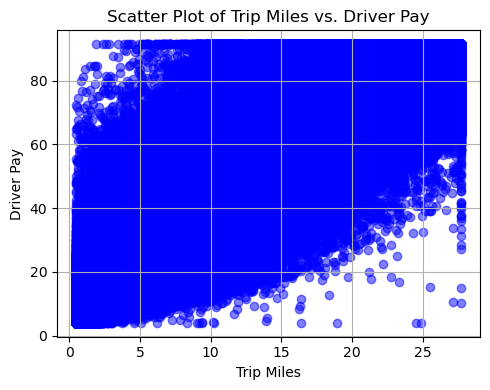

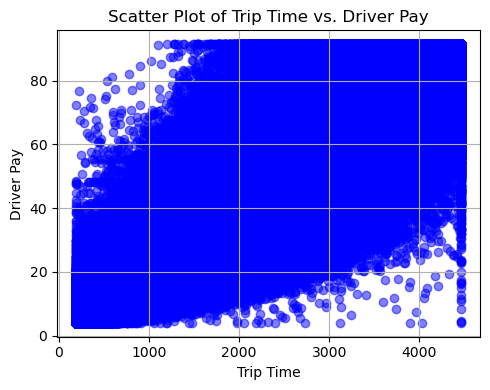

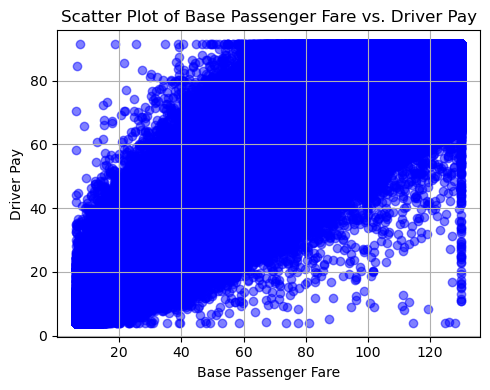

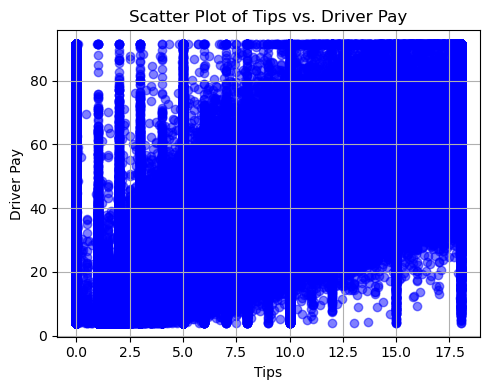

In [37]:
# Set feature and target variables
target_variable = 'driver_pay'
feature_variables = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']

# Scatter plots for features against target
for feature in feature_variables:
    plt.figure(figsize=(5, 4)) # Create a new figure for each plot
    plt.scatter(train_df2[feature], train_df2[target_variable], alpha=0.5, color='b')
    plt.title(f'Scatter Plot of {feature.replace("_", " ").title()} vs. Driver Pay')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Driver Pay')
    plt.grid(True)
    plt.tight_layout() # Ensures labels are not cut off

In [38]:
# Cateogorical columns 
categorical_columns = ['hvfhs_license_num', 'shared_request_flag', 'shared_match_flag',
       'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag',
       'week_number', 'pickup_hour', 'pickup_dayofweek', 'is_weekend', 'pickup_dayofmonth', 
       'time_of_day', 'is_high_tip', 'is_night_ride']

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 40, Finished, Available, Finished)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 41, Finished, Available, Finished)

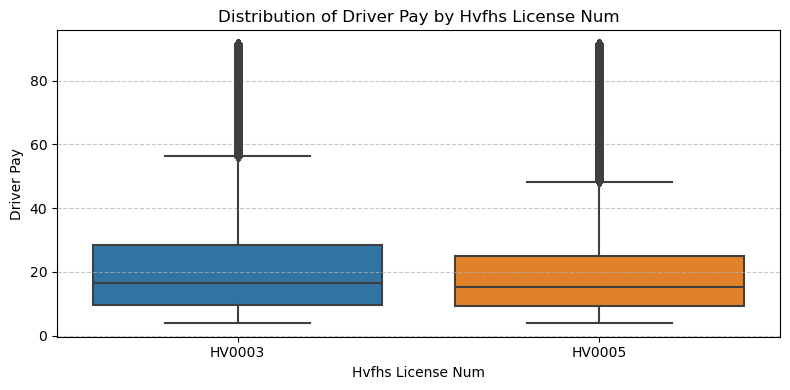

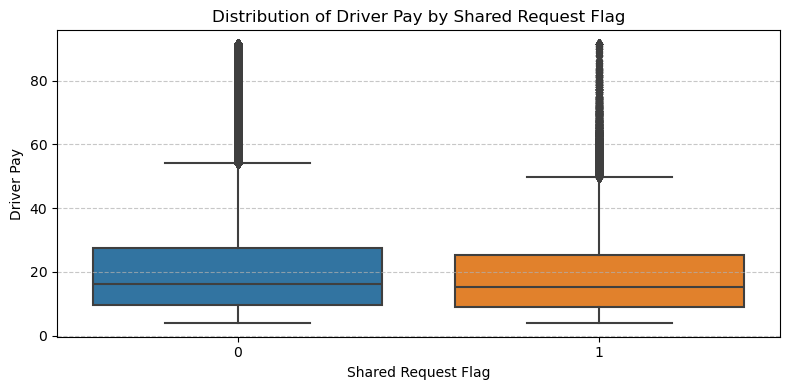

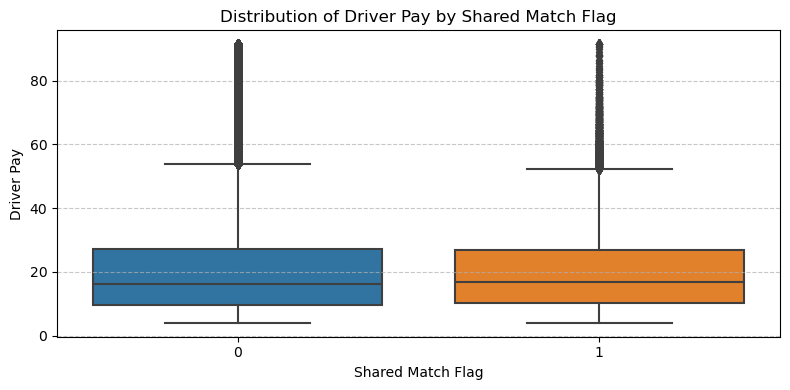

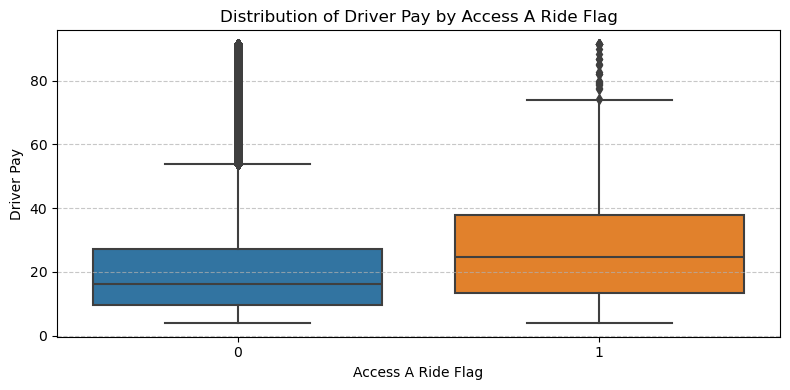

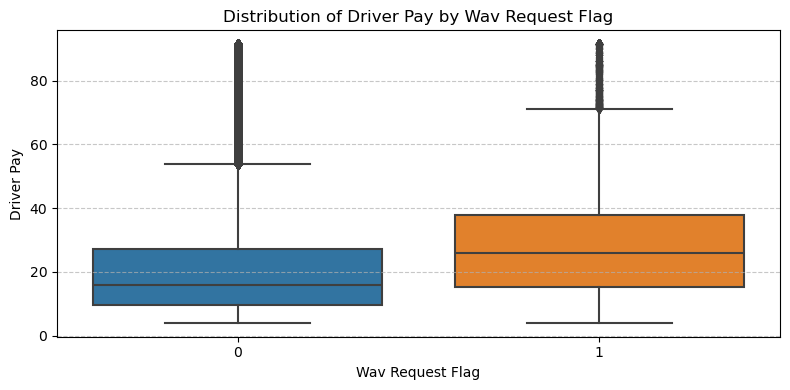

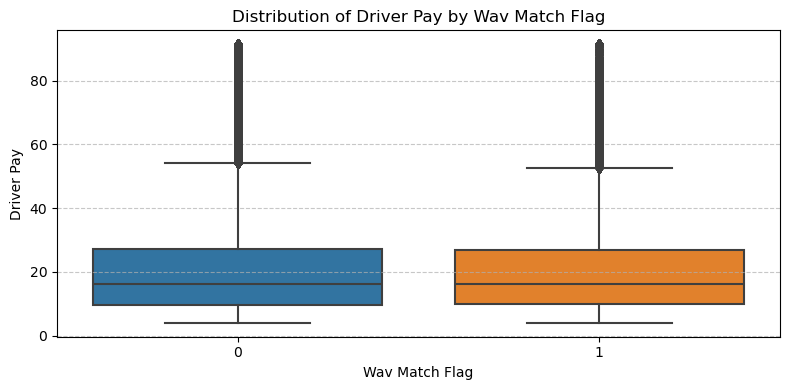

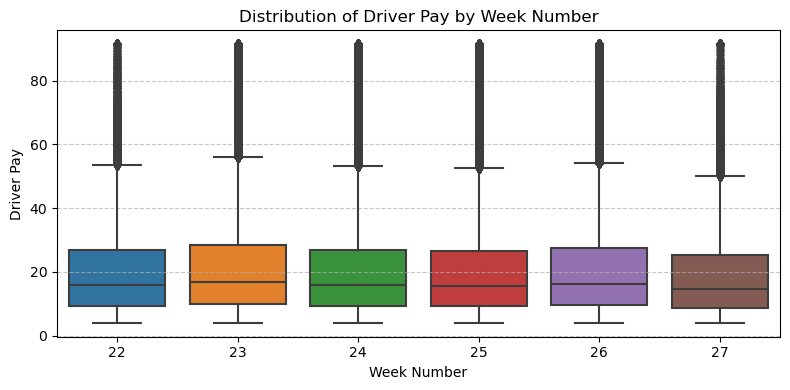

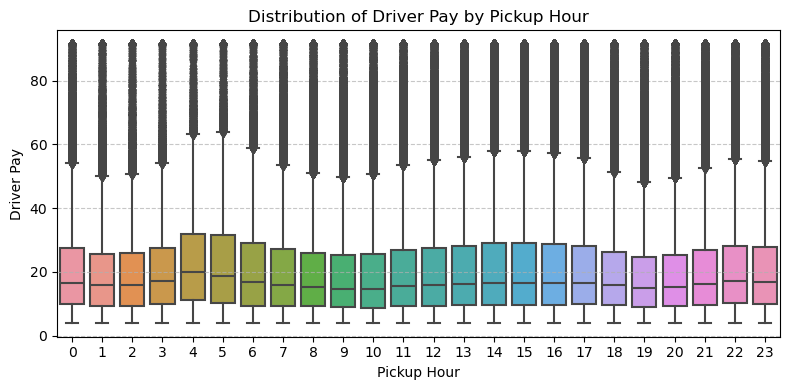

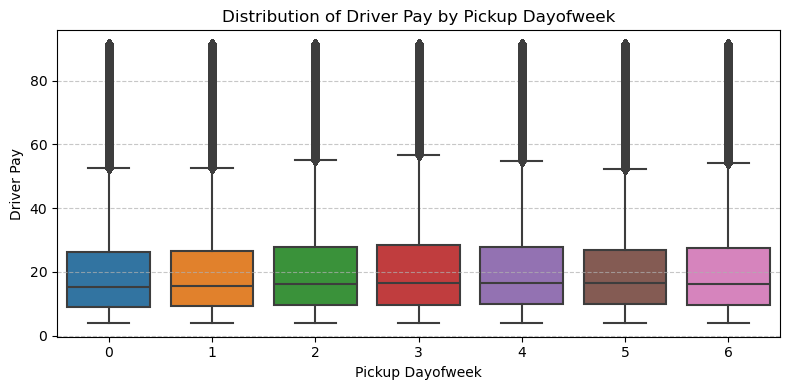

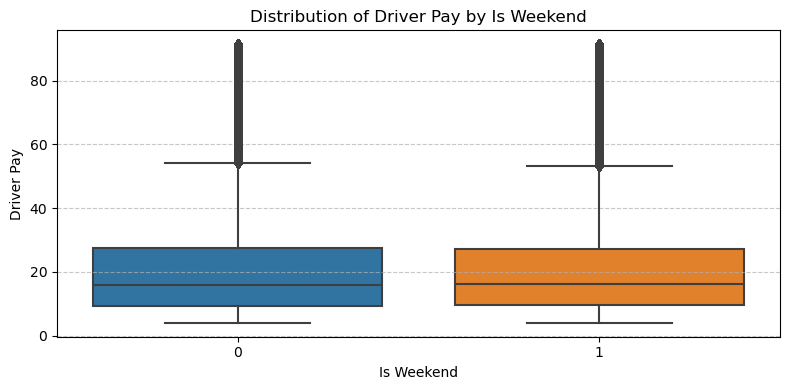

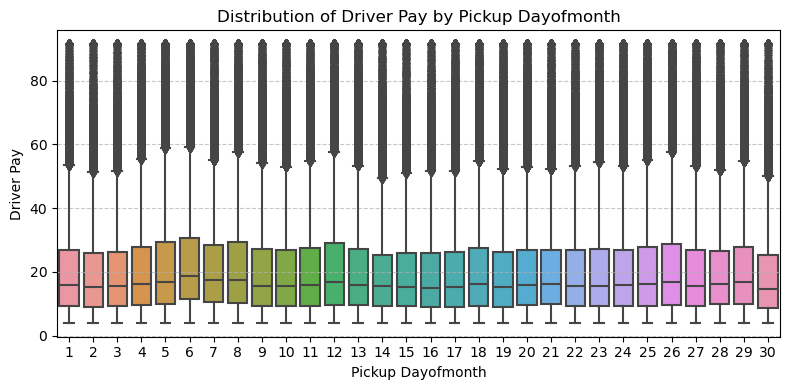

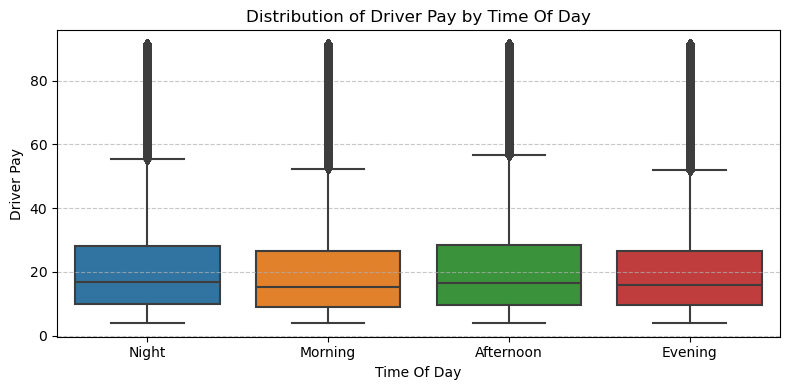

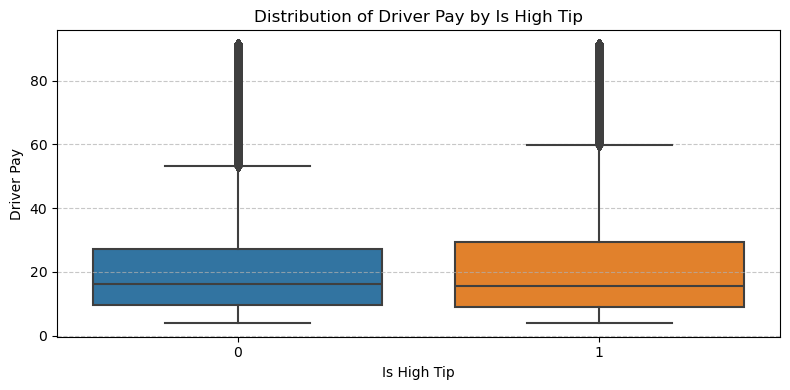

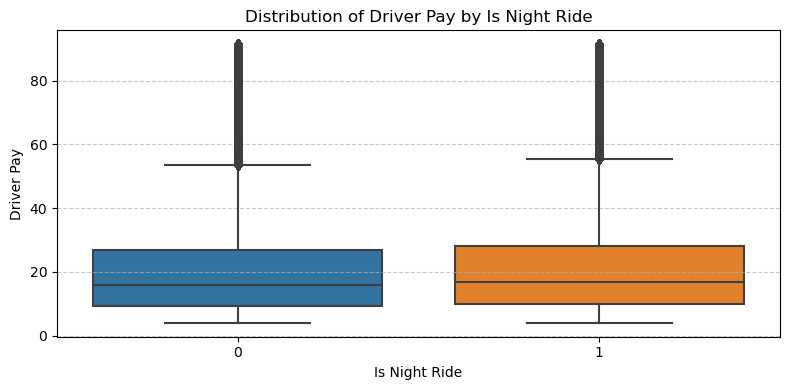

In [39]:
# Step 3: Create a boxplot for each categorical feature against the target.
for feature in categorical_columns:
    plt.figure(figsize=(8, 4))

    # Build boxplots    
    sns.boxplot(x=feature, y=target_variable, data=train_df2)
    
    # Customize plot
    plt.title(f'Distribution of Driver Pay by {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Driver Pay')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

## Feature Engineering

In [40]:
# Missing values? 
train_df2.isnull().sum()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 42, Finished, Available, Finished)

hvfhs_license_num       0
pickup_datetime         0
trip_miles              0
trip_time               0
base_passenger_fare     0
tolls                   0
bcf                     0
sales_tax               0
congestion_surcharge    0
airport_fee             0
tips                    0
driver_pay              0
shared_request_flag     0
shared_match_flag       0
access_a_ride_flag      0
wav_request_flag        0
wav_match_flag          0
cbd_congestion_fee      0
week_number             0
pickup_hour             0
pickup_dayofweek        0
is_weekend              0
pickup_dayofmonth       0
time_of_day             0
driver_pay_per_mile     0
is_high_tip             0
is_night_ride           0
dtype: int64

In [41]:
# Drop pickup date time col 
train_df2.drop('pickup_datetime', axis=1, inplace=True)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 43, Finished, Available, Finished)

### Log-transformations

In [42]:
# copy df 
train_df3 = train_df2.copy()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 44, Finished, Available, Finished)

In [43]:
# Shape 
train_df3.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 45, Finished, Available, Finished)

(2000000, 26)

In [44]:
# Info 
train_df3.info()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 46, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 11322195 to 6340764
Data columns (total 26 columns):
 #   Column                Dtype   
---  ------                -----   
 0   hvfhs_license_num     object  
 1   trip_miles            float64 
 2   trip_time             int64   
 3   base_passenger_fare   float64 
 4   tolls                 float64 
 5   bcf                   float64 
 6   sales_tax             float64 
 7   congestion_surcharge  float64 
 8   airport_fee           float64 
 9   tips                  float64 
 10  driver_pay            float64 
 11  shared_request_flag   int64   
 12  shared_match_flag     int64   
 13  access_a_ride_flag    int64   
 14  wav_request_flag      int64   
 15  wav_match_flag        int64   
 16  cbd_congestion_fee    float64 
 17  week_number           UInt32  
 18  pickup_hour           int32   
 19  pickup_dayofweek      int32   
 20  is_weekend            int64   
 21  pickup_dayofmonth     int32   
 22  time_of_day     

In [45]:
# Describe 
train_df3[continous_features].describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 47, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,5.00,1209.28,27.55,1.07,0.69,2.29,0.97,0.22,1.16,21.28,0.51,5.54
std,5.20,846.95,22.73,3.34,0.59,1.93,1.31,0.71,3.11,16.94,0.71,2.69
min,0.48,194.00,6.19,0.00,0.13,0.00,0.00,0.00,0.00,4.00,0.00,2.44
25%,1.56,600.00,12.67,0.00,0.31,1.04,0.00,0.00,0.00,9.48,0.00,3.84
50%,3.03,978.00,19.99,0.00,0.49,1.68,0.00,0.00,0.00,16.05,0.00,4.91
75%,6.42,1566.00,33.57,0.00,0.84,2.86,2.75,0.00,0.00,27.25,1.50,6.30
max,27.69,4459.00,129.90,18.52,3.34,10.55,2.75,2.50,18.03,91.44,1.50,18.30


In [46]:
# log1p transformation of continuous features
train_df3[continous_features] = train_df3[continous_features].apply(np.log1p)
print("Log transformation applied to columns:")
print(continous_features)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 48, Finished, Available, Finished)

Log transformation applied to columns:
['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay', 'cbd_congestion_fee', 'driver_pay_per_mile']


In [47]:
# Describe 
train_df3[continous_features].describe()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 49, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,1.52,6.87,3.12,0.26,0.48,1.06,0.47,0.11,0.34,2.87,0.31,1.81
std,0.71,0.68,0.65,0.73,0.28,0.49,0.63,0.36,0.74,0.68,0.43,0.34
min,0.39,5.27,1.97,0.00,0.12,0.00,0.00,0.00,0.00,1.61,0.00,1.24
25%,0.94,6.40,2.62,0.00,0.27,0.71,0.00,0.00,0.00,2.35,0.00,1.58
50%,1.39,6.89,3.04,0.00,0.40,0.99,0.00,0.00,0.00,2.84,0.00,1.78
75%,2.00,7.36,3.54,0.00,0.61,1.35,1.32,0.00,0.00,3.34,0.92,1.99
max,3.36,8.40,4.87,2.97,1.47,2.45,1.32,1.25,2.95,4.53,0.92,2.96


### Standard Scaler
for feature scaling

In [48]:
# Copy to new df
train_df4 = train_df3.copy()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 50, Finished, Available, Finished)

In [49]:
# Shape 
train_df4.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 51, Finished, Available, Finished)

(2000000, 26)

Only independant variables are put through Standard Scaling. The target variable has to be excluded.

In [50]:
# Set continuous variables for scaling, exclude driver pay
scaled_continuous_features = ['trip_miles', 'trip_time', 'base_passenger_fare',
                            'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
                            'airport_fee', 'tips', 'cbd_congestion_fee', 'driver_pay_per_mile']
scaled_continuous_features                            

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 52, Finished, Available, Finished)

['trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'cbd_congestion_fee',
 'driver_pay_per_mile']

In [51]:
# Initialize Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform continuous features 
train_df4[scaled_continuous_features] = scaler.fit_transform(train_df4[scaled_continuous_features]) 

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 53, Finished, Available, Finished)

In [37]:
# Describe 
train_df4[continous_features].describe()

StatementMeta(, b511a5df-c073-4313-b1b4-c100b595ce98, 39, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,2.75,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.65,1.00,1.00
min,-1.56,-2.38,-1.67,-0.35,-1.22,-2.26,-0.77,-0.29,-0.45,1.61,-0.67,-1.72
25%,-0.81,-0.70,-0.80,-0.35,-0.75,-0.71,-0.77,-0.29,-0.45,2.24,-0.67,-0.73
50%,-0.19,0.03,-0.12,-0.35,-0.26,-0.16,-0.77,-0.29,-0.45,2.70,-0.67,-0.08
75%,0.68,0.72,0.64,-0.35,0.44,0.58,1.31,-0.29,-0.45,3.20,1.49,0.54
max,2.61,2.20,2.79,3.99,3.57,2.88,1.31,3.52,3.55,4.36,1.49,3.29


StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 54, Finished, Available, Finished)

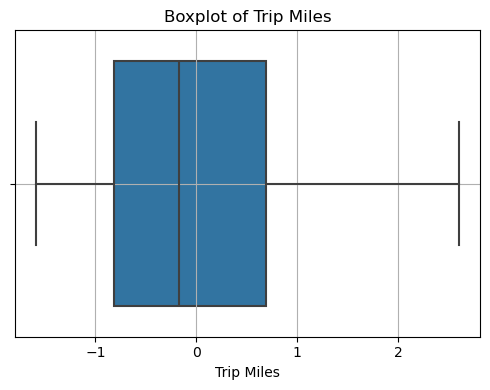

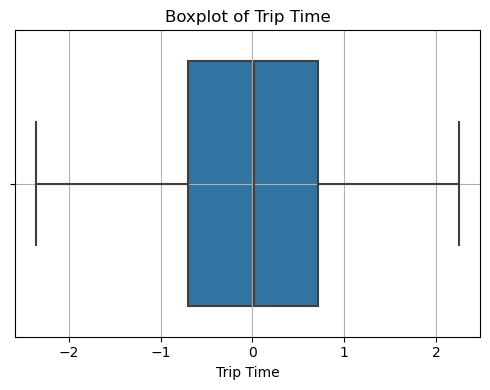

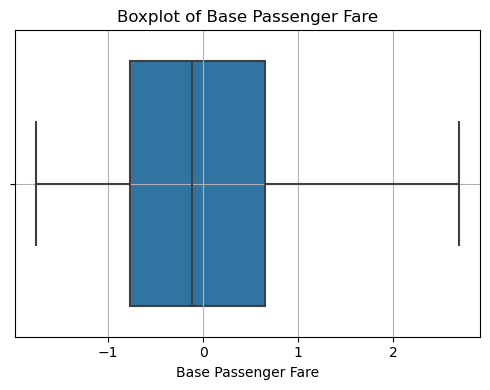

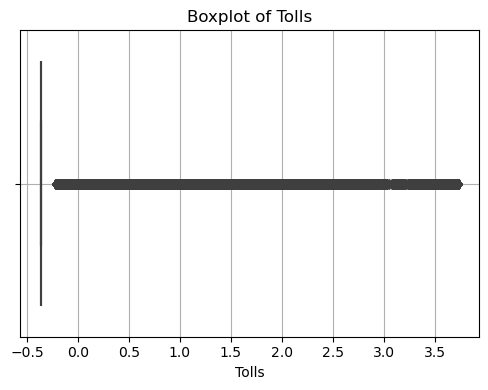

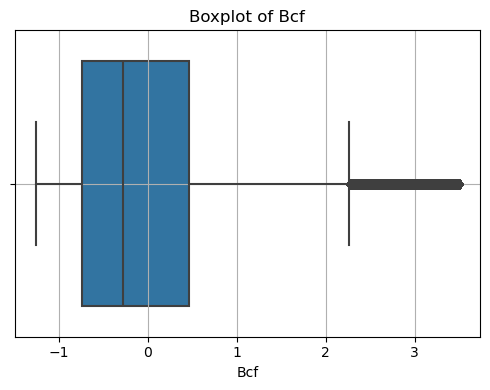

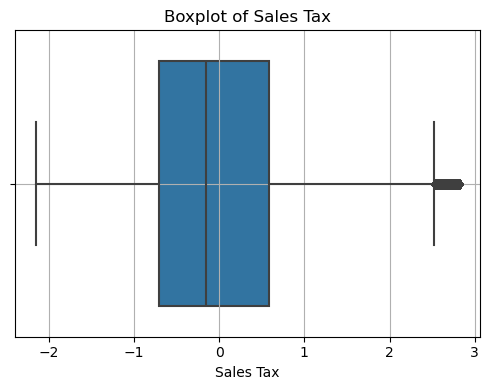

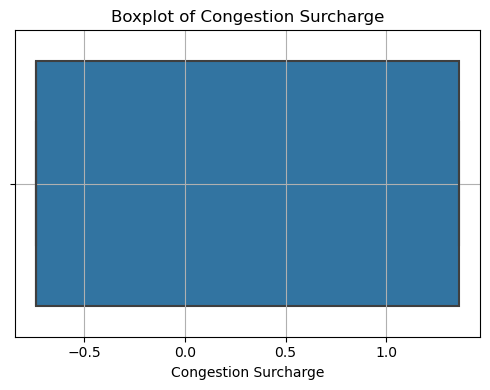

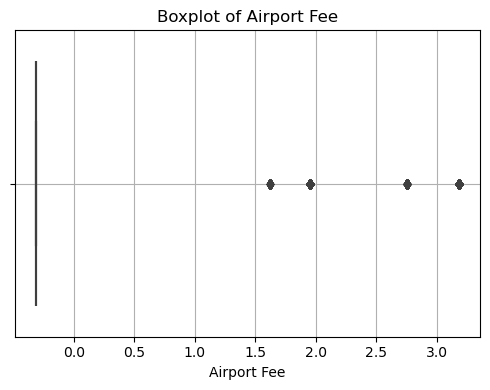

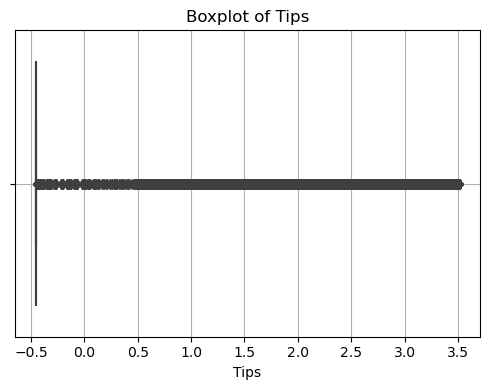

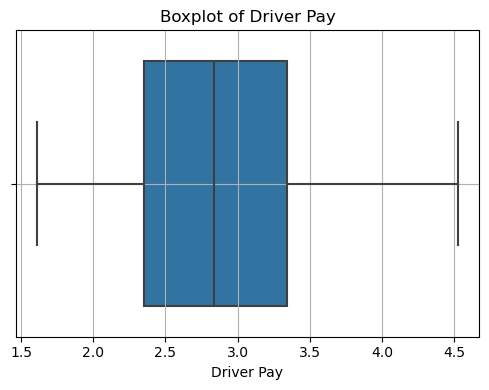

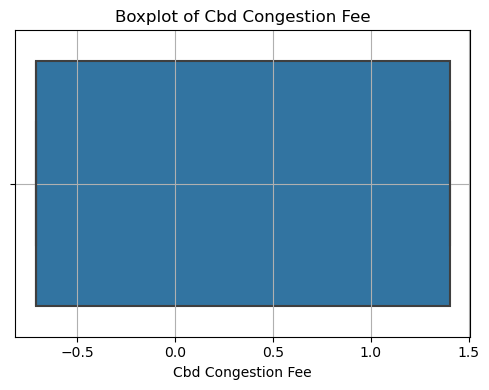

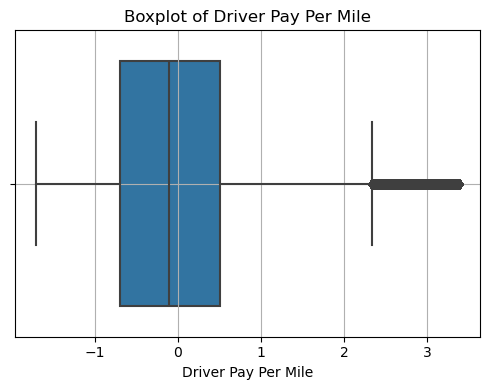

In [52]:
# Boxplots after feature transformations
for feature in continous_features:
    plt.figure(figsize=(5, 4)) # new figure for each plot
    
    # boxplots 
    sns.boxplot(x=train_df4[feature])
    
    plt.title(f'Boxplot of {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.grid(True)
    plt.tight_layout()

### Correlations

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 55, Finished, Available, Finished)

                      trip_miles  trip_time  base_passenger_fare  tolls   bcf  \
trip_miles                  1.00       0.86                 0.85   0.53  0.83   
trip_time                   0.86       1.00                 0.85   0.42  0.80   
base_passenger_fare         0.85       0.85                 1.00   0.50  0.96   
tolls                       0.53       0.42                 0.50   1.00  0.56   
bcf                         0.83       0.80                 0.96   0.56  1.00   
sales_tax                   0.62       0.65                 0.74   0.14  0.70   
congestion_surcharge        0.09       0.19                 0.31   0.09  0.26   
airport_fee                 0.44       0.33                 0.43   0.33  0.48   
tips                        0.17       0.17                 0.25   0.15  0.26   
driver_pay                  0.91       0.93                 0.93   0.48  0.89   
cbd_congestion_fee          0.14       0.24                 0.36   0.23  0.33   
driver_pay_per_mile        -

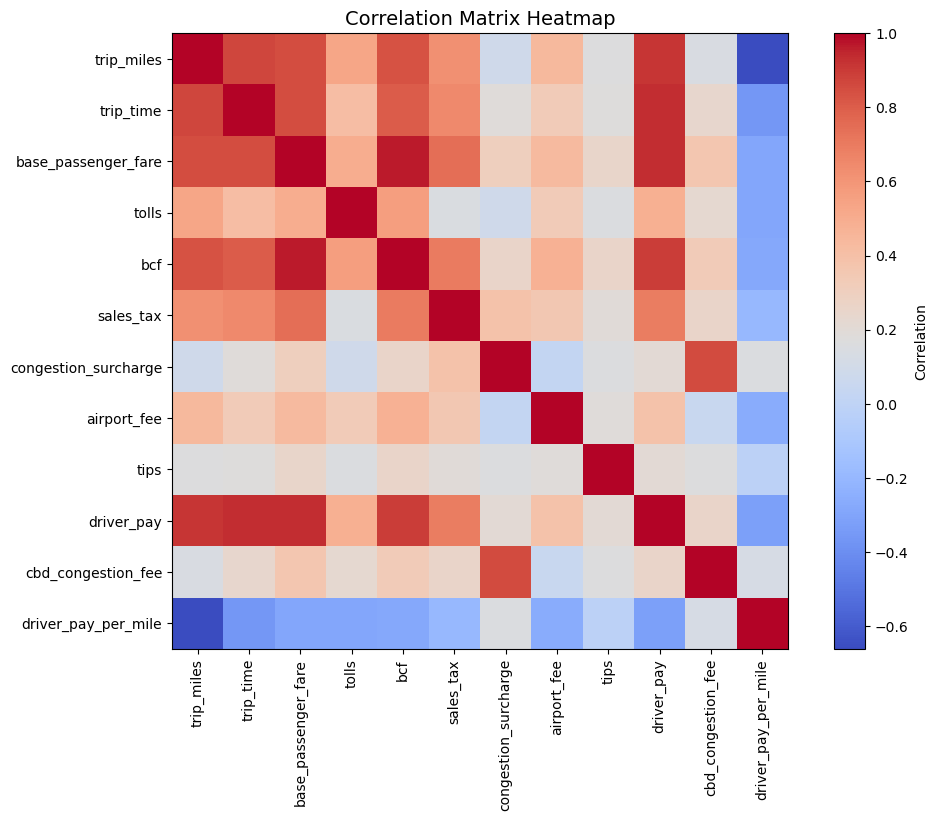

In [53]:
# Correlation matrix
corr_matrix = train_df4[continous_features].corr()

# Print correlation matrix
print(corr_matrix)

# Optional: Heatmap for better visualization
plt.figure(figsize=(12, 8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.show()


### One-hot encoding

In [54]:
# Copy df as new 
train_df5 = train_df4.copy()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 56, Finished, Available, Finished)

In [55]:
# Shape  
train_df5.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 57, Finished, Available, Finished)

(2000000, 26)

In [56]:
# Drop week_number 
train_df5.drop(columns='week_number', inplace=True)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 58, Finished, Available, Finished)

In [57]:
# Columns
train_df5.columns

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 59, Finished, Available, Finished)

Index(['hvfhs_license_num', 'trip_miles', 'trip_time', 'base_passenger_fare',
       'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee',
       'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
       'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag',
       'cbd_congestion_fee', 'pickup_hour', 'pickup_dayofweek', 'is_weekend',
       'pickup_dayofmonth', 'time_of_day', 'driver_pay_per_mile',
       'is_high_tip', 'is_night_ride'],
      dtype='object')

In [58]:
# List categorical columns
categorical_columns.remove('week_number')
categorical_columns

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 60, Finished, Available, Finished)

['hvfhs_license_num',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'pickup_hour',
 'pickup_dayofweek',
 'is_weekend',
 'pickup_dayofmonth',
 'time_of_day',
 'is_high_tip',
 'is_night_ride']

In [59]:
# Libraries for encoder and joblib
from sklearn.preprocessing import OneHotEncoder
import joblib

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 61, Finished, Available, Finished)

In [60]:
# Initialize and fit the encoder on categorical features/columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoded_data = encoder.fit_transform(train_df5[categorical_columns])

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 62, Finished, Available, Finished)

In [61]:
# View 
encoded_data

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 63, Finished, Available, Finished)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Encoded data is a numpy array

In [62]:
# Save the fitted encoder object (to use in predictions on new data)
joblib.dump(encoder, '/lakehouse/default/Files/models/one_hot_encoder.joblib')
print("Encoder saved successfully.")

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 64, Finished, Available, Finished)

Encoder saved successfully.


In [63]:
# Get column names from encoder
feature_names = encoder.get_feature_names_out(categorical_columns)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 65, Finished, Available, Finished)

In [64]:
# Encoded df
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, dtype=int)
encoded_df.head()

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 66, Finished, Available, Finished)

,hvfhs_license_num_HV0005,shared_request_flag_1,shared_match_flag_1,access_a_ride_flag_1,wav_request_flag_1,wav_match_flag_1,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,...,pickup_dayofmonth_26,pickup_dayofmonth_27,pickup_dayofmonth_28,pickup_dayofmonth_29,pickup_dayofmonth_30,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,is_high_tip_1,is_night_ride_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [65]:
# Replace categorical columns from train_df5 with new encoded columns
train_df5.drop(columns=categorical_columns, inplace=True)

# concatenate with df as new
train_df6 = pd.concat([train_df5.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 67, Finished, Available, Finished)

In [66]:
# Display 
display(train_df6)

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 68, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 886a6784-4cb7-43fb-9b92-ee7db7e8aecf)

In [67]:
# Shape 
train_df6.shape

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 69, Finished, Available, Finished)

(2000000, 82)

### Write back to lakehouse 

In [68]:
# Write train_df4 to lakehouse engineered folder
train_df6.to_parquet("/lakehouse/default/Files/engineered/train_df6.parquet")

StatementMeta(, 2243ad58-1437-4afd-88b3-21758b895f55, 70, Finished, Available, Finished)